In [1]:
import os
import sys
import warnings
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from autofeat import AutoFeatClassifier

%matplotlib inline
%load_ext autoreload
%autoreload 2

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
np.seterr(divide = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# same interface for loading all datasets
def load_classification_dataset(name):
    # load one of the datasets as X and y
    units = {}
    if name == "iris":
        # sklearn iris housing dataset
        X, y = load_iris(True)

    elif name == "wine":
        # sklearn wine dataset
        X, y = load_wine(True)
    
    elif name == "breast_cancer":
        # sklearn breast_cancer dataset
        X, y = load_breast_cancer(True)

    else:
        raise RuntimeError("Unknown dataset %r" % name)
    return np.array(X, dtype=float), np.array(y, dtype=float), units

In [3]:
def test_model(X, y, model, param_grid):
    # load data
    #X, y, _ = load_classification_dataset(dataset)
    # split in training and test parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    
    if model.__class__.__name__ == "SVC":
        sscaler = StandardScaler()
        X_train = sscaler.fit_transform(X_train)
        X_test = sscaler.transform(X_test)
    
    # train model on train split incl cross-validation for parameter selection
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gsmodel = GridSearchCV(model, param_grid, cv=5)
        gsmodel.fit(X_train, y_train)
    print("best params:", gsmodel.best_params_)
    print("best score:", gsmodel.best_score_)
    print("Acc. on training data:", accuracy_score(y_train, gsmodel.predict(X_train)))
    print("Acc. on test data:", accuracy_score(y_test, gsmodel.predict(X_test)))
    return gsmodel.best_estimator_

def test_autofeat(X, y, units, feateng_steps=2):
    # load data
    #X, y, units = load_classification_dataset(dataset)
    # split in training and test parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    # run autofeat
    afclas = AutoFeatClassifier(verbose=1, feateng_steps=feateng_steps, units=units)
    # fit autofeat on less data, otherwise ridge reg model with xval will overfit on new features
    X_train_tr = afclas.fit_transform(X_train, y_train)
    X_test_tr = afclas.transform(X_test)
    print("autofeat new features:", len(afclas.new_feat_cols_))
    print("autofeat Acc. on training data:", accuracy_score(y_train, afclas.predict(X_train_tr)))
    print("autofeat Acc. on test data:", accuracy_score(y_test, afclas.predict(X_test_tr)))
    
    # train rreg on transformed train split incl cross-validation for parameter selection
    print("# Logistic Regression")
    rreg = LogisticRegression(class_weight="balanced")
    param_grid = {"C": np.logspace(-4, 4, 10)}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gsmodel = GridSearchCV(rreg, param_grid, cv=5)
        gsmodel.fit(X_train_tr, y_train)
    print("best params:", gsmodel.best_params_)
    print("best score:", gsmodel.best_score_)
    print("Acc. on training data:", accuracy_score(y_train, gsmodel.predict(X_train_tr)))
    print("Acc. on test data:", accuracy_score(y_test, gsmodel.predict(X_test_tr)))
    
    print("# Random Forest")
    rforest = RandomForestClassifier(n_estimators=100, random_state=13)
    param_grid = {"min_samples_leaf": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]}
    gsmodel = GridSearchCV(rforest, param_grid, cv=5)
    gsmodel.fit(X_train_tr, y_train)
    print("best params:", gsmodel.best_params_)
    print("best score:", gsmodel.best_score_)
    print("Acc. on training data:", accuracy_score(y_train, gsmodel.predict(X_train_tr)))
    print("Acc. on test data:", accuracy_score(y_test, gsmodel.predict(X_test_tr)))
    
    print("# SVC")
    svc = SVC(gamma="scale", class_weight="balanced")
    param_grid = {"C": [1., 10., 25., 50., 100., 250.]}
    sscaler = StandardScaler()
    X_train_tr = sscaler.fit_transform(X_train_tr)
    X_test_tr = sscaler.transform(X_test_tr)
    gsmodel = GridSearchCV(svc, param_grid, cv=5)
    gsmodel.fit(X_train_tr, y_train)
    print("best params:", gsmodel.best_params_)
    print("best score:", gsmodel.best_score_)
    print("Acc. on training data:", accuracy_score(y_train, gsmodel.predict(X_train_tr)))
    print("Acc. on test data:", accuracy_score(y_test, gsmodel.predict(X_test_tr)))

In [4]:
dsname = 'iris'
print("####", dsname)
X, y, _ = load_classification_dataset(dsname)
print(X.shape, np.unique(y))

#### iris
(150, 4) [0. 1. 2.]


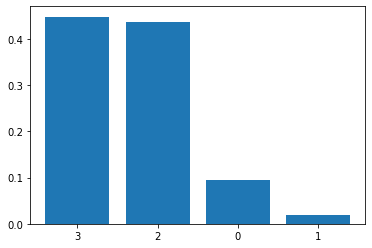

In [5]:
#randomforest illesztése a kibővített adathalmazra, hogy feature importance-t alkalmazzunk rajta
randforclas = RandomForestClassifier(random_state=13)
randforclas.fit(X, y)
#feature importance alkalmazása és ábrázolása
importances = randforclas.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()

In [6]:
select = []
#kiválasztom a legfontosabb featureket
for i,v in enumerate(importances):
    if v > 0.2:
        select.append(i)
XS = X[:,select]
XS.shape

(150, 2)

In [7]:
print("####", dsname)
rreg = LogisticRegression(class_weight="balanced")
params = {"C": np.logspace(-4, 4, 10)}
rreg = test_model(XS, y, rreg, params)

#### iris
best params: {'C': 0.3593813663804626}
best score: 0.9666666666666666
Acc. on training data: 0.9666666666666667
Acc. on test data: 0.9666666666666667


In [8]:
print("####", dsname)
rforest = RandomForestClassifier(n_estimators=100, random_state=13)
params = {"min_samples_leaf": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]}
rforest = test_model(XS, y, rforest, params)

#### iris
best params: {'min_samples_leaf': 0.2}
best score: 0.9583333333333334
Acc. on training data: 0.975
Acc. on test data: 0.9333333333333333


In [9]:
print("####", dsname)
svc = SVC(gamma="scale", class_weight="balanced")
params = {"C": [1., 10., 25., 50., 100., 250.]}
svc = test_model(XS, y, svc, params)

#### iris
best params: {'C': 1.0}
best score: 0.95
Acc. on training data: 0.9583333333333334
Acc. on test data: 0.9666666666666667


In [10]:
print("####", dsname)
test_autofeat(XS, y, _, feateng_steps=1)

#### iris
[AutoFeat] The 1 step feature engineering process could generate up to 14 features.
[AutoFeat] With 120 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 12 transformed features from 2 original features - done.
[feateng] Generated altogether 12 new features in 1 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 6 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 5 features after 5 feature selection runs
[featsel] 4 features after correlation filtering
[featsel] 3 features after noise filtering
[AutoFeat] Computing 2 new features.
[AutoFeat]     2/    2 new features ...done.
[AutoFeat] Final dataframe with 4 feature columns (2 ne

In [11]:
print("####", dsname)
test_autofeat(XS, y, _, feateng_steps=2)

#### iris
[AutoFeat] The 2 step feature engineering process could generate up to 105 features.
[AutoFeat] With 120 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 12 transformed features from 2 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 83 feature combinations from 91 original feature tuples - done.
[feateng] Generated altogether 96 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 19 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 9 features after 5 feature selection runs
[featsel] 4 features after correlation filtering
[featsel] 4 features after noise filtering
[Au

In [12]:
print("####", dsname)
test_autofeat(XS, y, _, feateng_steps=3)

#### iris
[AutoFeat] The 3 step feature engineering process could generate up to 2289 features.
[AutoFeat] With 120 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 12 transformed features from 2 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 356 feature combinations from 91 original feature tuples - done.
[feateng] Step 3: transformation of new features
[feateng] Generated 1607 transformed features from 356 original features - done.
[feateng] Generated altogether 2031 new features in 3 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 1161 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 2